# Question A2 (10 marks)

### In this question, we will determine the optimal batch size for mini-batch gradient descent. Find the optimal batch size for mini-batch gradient descent by training the neural network and evaluating the performances for different batch sizes. Note: Use 5-fold cross-validation on training partition to perform hyperparameter selection. You will have to reconsider the scaling of the dataset during the 5-fold cross validation.

* note: some cells are non-editable and cannot be filled, but leave them untouched. Fill up only cells which are provided.

#### Plot mean cross-validation accuracies on the final epoch for different batch sizes as a scatter plot. Limit search space to batch sizes {128, 256, 512, 1024}. Next, create a table of time taken to train the network on the last epoch against different batch sizes. Finally, select the optimal batch size and state a reason for your selection.

This might take a while to run, so plan your time carefully.

In [209]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# setting seed
set_seed()

2. To reduce repeated code, place your

- network (MLP defined in QA1)
- torch datasets (CustomDataset defined in QA1)
- loss function (loss_fn defined in QA1)

in a separate file called **common_utils.py**

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.

In [210]:
from common_utils import MLP, split_dataset, preprocess_dataset, CustomDataset, loss_fn
import pandas as pd

def preprocess(df):
    
    X_train, y_train, X_test, y_test = split_dataset(df,['filename','label'],0.3,0)
    X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)

    return X_train_scaled, y_train, X_test_scaled, y_test

df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]

X_train_scaled, y_train, X_test_scaled, y_test = preprocess(df)

train_data = CustomDataset(X_train_scaled, y_train)
test_data = CustomDataset(X_test_scaled, y_test)


3. Define different folds for different batch sizes to get a dictionary of training and validation datasets. Preprocess your datasets accordingly.

In [211]:
def generate_cv_folds_for_batch_sizes(parameters, X_train, y_train):
    """
    returns:
    X_train_scaled_dict(dict) where X_train_scaled_dict[batch_size] is a list of the preprocessed training matrix for the different folds.
    X_val_scaled_dict(dict) where X_val_scaled_dict[batch_size] is a list of the processed validation matrix for the different folds.
    y_train_dict(dict) where y_train_dict[batch_size] is a list of labels for the different folds
    y_val_dict(dict) where y_val_dict[batch_size] is a list of labels for the different folds
    """
    
    X_train_scaled_dict = {}
    X_val_scaled_dict = {}
    y_train_dict = {}
    y_val_dict = {}

    kf = KFold(n_splits=5, shuffle=True, random_state=0)

    for batch_size in parameters:
        X_train_scaled_dict[batch_size] = []
        X_val_scaled_dict[batch_size] = []
        y_train_dict[batch_size] = []
        y_val_dict[batch_size] = []

        
        for train_index, val_index in kf.split(X_train):
            X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

            X_train_scaled_dict[batch_size].append(X_train_fold)
            X_val_scaled_dict[batch_size].append(X_val_fold)
            y_train_dict[batch_size].append(y_train_fold)
            y_val_dict[batch_size].append(y_val_fold)

    return X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict

batch_sizes = [128, 256, 512, 1024]
X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict = generate_cv_folds_for_batch_sizes(batch_sizes, X_train_scaled, y_train)


4. Perform hyperparameter tuning for the different batch sizes with 5-fold cross validation.

In [212]:
from common_utils import EarlyStopper

epochs = 100
early_stopper = EarlyStopper(patience=3, min_delta=0)

def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()
        correct += ((pred > 0.5).type(torch.float) == y).type(torch.float).sum().item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    train_loss /= num_batches
    correct /= size
    print(f"Train Error: \n Accuracy: {(correct*100):>0.1f}%, Avg loss: {train_loss:>8f} \n")
    
    return train_loss, correct

def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += ((pred > 0.5).type(torch.float) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    return test_loss, correct

def find_optimal_hyperparameter(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, parameters, parameter_name):
    """
    returns:
    cross_validation_accuracies(list) where cross_validation_accuracies[i] is the cross validation accuracy for the ith parameter value
    cross_validation_times(list) where cross_validation_times[i] is the mean time taken on the last epoch for the ith parameter value
    """

    cross_validation_accuracies = []
    cross_validation_times = []

    for parameter in parameters:
        print(f"Training for {parameter_name} = {parameter}")
        accuracies = []
        times = []

        for i in range(5):
            print(f"Fold {i+1}")
            model = MLP(77,128,1)
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
            loss_fn = nn.BCELoss()
            early_stopper = EarlyStopper(patience=3, min_delta=0)

            train_data = CustomDataset(X_train_scaled_dict[parameter][i], y_train_dict[parameter][i])
            val_data = CustomDataset(X_val_scaled_dict[parameter][i], y_val_dict[parameter][i])

            train_dataloader = DataLoader(train_data, batch_size=parameter, shuffle=True)
            val_dataloader = DataLoader(val_data, batch_size=parameter, shuffle=True)

            train_loss, test_loss = [], []
            train_acc, test_acc = [], []
            epoch_times = []
            
            for t in range(epochs):
                
                print(f"Epoch {t+1}\n-------------------------------")

                # Training Loop
                start = time.time()
                tr_loss, acc = train_loop(train_dataloader, model, loss_fn, optimizer)
                train_loss.append(tr_loss), train_acc.append(acc)

                # Validation Loop
                te_loss, acc = test_loop(val_dataloader, model, loss_fn)
                test_loss.append(te_loss), test_acc.append(acc)
                end = time.time()

                epoch_times.append(end-start)

                if early_stopper.early_stop(te_loss): 
                    print("Done!")                    
                    break
            
            # Accuracy for the current Fold at last Epoch
            accuracies.append(test_acc[-1])

            # Time taken for the current Fold at last Epoch
            times.append(epoch_times[-1])

        # Mean Accuracy for the Batch Size (Mean of Accuracy at Last Epoch for each Fold)
        cross_validation_accuracies.append(np.mean(accuracies))

        # Mean Time taken for the Batch Size (Mean of Time at Last Epoch for each Fold)
        cross_validation_times.append(np.mean(times))

    return cross_validation_accuracies, cross_validation_times

batch_sizes = [128, 256, 512, 1024]
cross_validation_accuracies, cross_validation_times = find_optimal_hyperparameter(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, batch_sizes, 'batch_size')

Training for batch_size = 128
Fold 1
Epoch 1
-------------------------------
loss: 0.700155  [  128/ 6751]
Train Error: 
 Accuracy: 54.2%, Avg loss: 0.688382 

Test Error: 
 Accuracy: 57.6%, Avg loss: 0.675743 

Epoch 2
-------------------------------
loss: 0.686896  [  128/ 6751]
Train Error: 
 Accuracy: 57.8%, Avg loss: 0.674810 

Test Error: 
 Accuracy: 61.1%, Avg loss: 0.660796 

Epoch 3
-------------------------------
loss: 0.647043  [  128/ 6751]
Train Error: 
 Accuracy: 60.9%, Avg loss: 0.659785 

Test Error: 
 Accuracy: 62.3%, Avg loss: 0.648022 

Epoch 4
-------------------------------
loss: 0.637716  [  128/ 6751]
Train Error: 
 Accuracy: 62.4%, Avg loss: 0.645977 

Test Error: 
 Accuracy: 63.5%, Avg loss: 0.637697 

Epoch 5
-------------------------------
loss: 0.623387  [  128/ 6751]
Train Error: 
 Accuracy: 63.3%, Avg loss: 0.630230 

Test Error: 
 Accuracy: 64.5%, Avg loss: 0.639161 

Epoch 6
-------------------------------
loss: 0.570981  [  128/ 6751]
Train Error: 
 Acc

5. Plot scatterplot of mean cross validation accuracies for the different batch sizes.

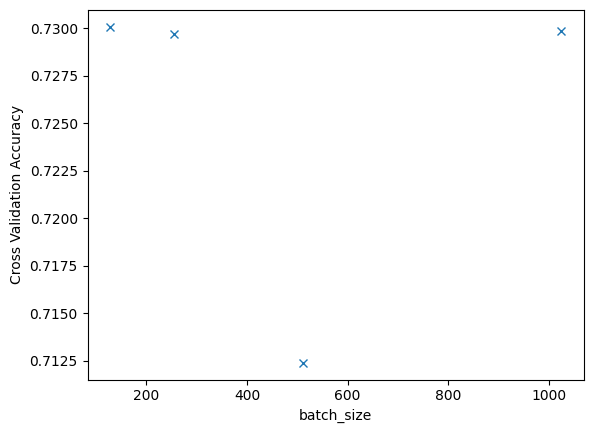

In [219]:
# YOUR CODE HERE
def plot_cross_validation_accuracies(cross_validation_accuracies, parameters, parameter_name):
    plt.plot(parameters, cross_validation_accuracies, marker='x',linestyle='None')
    plt.xlabel(parameter_name)
    plt.ylabel('Cross Validation Accuracy')
    plt.show()

plot_cross_validation_accuracies(cross_validation_accuracies, batch_sizes, 'batch_size')

6. Create a table of time taken to train the network on the last epoch against different batch sizes. Select the optimal batch size and state a reason for your selection.

In [214]:
df = pd.DataFrame({'Batch Size': batch_sizes,
                   'Last Epoch Time': cross_validation_times   
                  })

df

,Batch Size,Last Epoch Time
0,128,0.094197
1,256,0.077592
2,512,0.090675
3,1024,0.079741


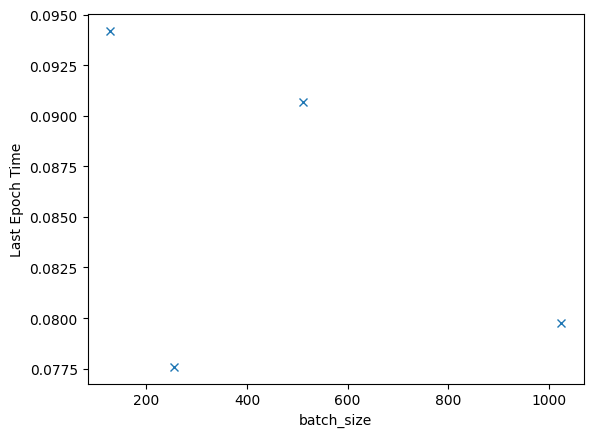

In [220]:
# plot last epoch time vs batch size

def plot_last_epoch_time_vs_batch_size(cross_validation_times, parameters, parameter_name):
    plt.plot(parameters, cross_validation_times, marker='x',linestyle='None')
    plt.xlabel(parameter_name)
    plt.ylabel('Last Epoch Time')
    plt.show()

plot_last_epoch_time_vs_batch_size(cross_validation_times, batch_sizes, 'batch_size')

In [216]:
# Sort df by Last Epoch Time and create a column measuring the percentage difference between each

df = df.sort_values(by=['Last Epoch Time'], ascending=False)
df['Percentage Difference'] = df['Last Epoch Time'].pct_change()*100
df


,Batch Size,Last Epoch Time,Percentage Difference
0,128,0.094197,NaN
2,512,0.090675,-3.739176
3,1024,0.079741,-12.058187
1,256,0.077592,-2.695213


In [217]:
batch_cv_accuracies = pd.DataFrame({'Batch Size': batch_sizes,
                   'Cross Validation Accuracy': cross_validation_accuracies                   
                  })

batch_cv_accuracies = batch_cv_accuracies.sort_values(by=['Cross Validation Accuracy'], ascending=False)
batch_cv_accuracies['Percentage Difference'] = batch_cv_accuracies['Cross Validation Accuracy'].pct_change()*100
batch_cv_accuracies

,Batch Size,Cross Validation Accuracy,Percentage Difference
0,128,0.730064,NaN
3,1024,0.729828,-0.032314
1,256,0.729710,-0.016254
2,512,0.712404,-2.371535


In [218]:
optimal_batch_size = 256
reason = '''
            We take 256 as the optimal batch size as the drop in accuracy from 128 is not significant (<0.05%) while the time taken to train on the last epoch is reduced by over 30%.

            In theory, 1024 is also a good candidate. However, we go with the first minimum obtained in terms of time take as it represents the best fit with the current machines CPU.
        '''